In [0]:
!pip install openpyxl

Collecting openpyxl
 Downloading openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.4 MB/s eta 0:00:00

Collecting et-xmlfile (from openpyxl)
 Downloading et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Installing collected packages: et-xmlfile, openpyxl
Successfully installed et-xmlfile-1.1.0 openpyxl-3.1.2

In [0]:
import os
import pandas as pd
import numpy as np
import base64
from tensorflow import keras
import seaborn as sns

from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report
from IPython.display import HTML

In [0]:
container ="data1"
data_path = f"abfss://{container}@capstone2023cuhk.dfs.core.windows.net/"
df_2021 = spark.read.csv(os.path.join(data_path, "AML-data", "Actual_Data_2021-2022", "ITEM_MATCHING_2021_BOOKS.csv"), header=True)
df_2022 = spark.read.csv(os.path.join(data_path, "AML-data", "Actual_Data_2021-2022", "ITEM_MATCHING_2022_BOOKS.csv"), header=True)
df_2021 = df_2021.toPandas()
df_2022 = df_2022.toPandas()

# Img
df_img_2021 = pd.DataFrame(dbutils.fs.ls("/FileStore/Bookimages"))
df_img_2021["PRODUCT_ID"] = df_img_2021["name"].apply(lambda x: x.replace(".jpg", ""))
df_img_2022 = pd.DataFrame(dbutils.fs.ls("/FileStore/Bookimages2022"))
df_img_2022["PRODUCT_ID"] = df_img_2022["name"].apply(lambda x: x.replace(".jpg", ""))

In [0]:
# Pre-processing
df_2021["PRODUCT_ID"] = df_2021["PRODUCT_ID"].apply(lambda x: x.strip())
df_2022["PRODUCT_ID"] = df_2022["PRODUCT_ID"].apply(lambda x: x.strip())

In [0]:
# Get only usable img: size != 807
df_img_2021 = df_img_2021[df_img_2021["size"] != 807]
df_img_2022 = df_img_2022[df_img_2022["size"] != 807]

df_img_2021 = df_img_2021[["PRODUCT_ID", "name"]]
df_img_2022 = df_img_2022[["PRODUCT_ID", "name"]]

df_2021 = df_2021[df_2021['PRICE']!='0']
df_2021 = df_2021[~df_2021['QTY_SALES'].isin([None, 'MBI       '])]
df_2022 = df_2022[df_2022['PRICE']!='0']
df_2022 = df_2022[~df_2022['QTY_SALES'].isin([None, 'MBI       '])]

df_2021["QTY_SALES"] = df_2021["QTY_SALES"].astype("int64")
df_2022["QTY_SALES"] = df_2022["QTY_SALES"].astype("int64")
df_2021["STD_SALES"] = minmax_scale(df_2021["QTY_SALES"], feature_range=(0, 1), axis=0, copy=True)
df_2022["STD_SALES"] = minmax_scale(df_2022["QTY_SALES"], feature_range=(0, 1), axis=0, copy=True)
# Remove outlier
# df_2021 = df_2021[df_2021['STD_SALES'] < df_2021["STD_SALES"].quantile(0.85)]

In [0]:
df_train = df_2021[["PRODUCT_ID", "QTY_SALES", "STD_SALES"]].merge(df_img_2021, on="PRODUCT_ID")
df_test = df_2022[["PRODUCT_ID", "QTY_SALES", "STD_SALES"]].merge(df_img_2022, on="PRODUCT_ID")
# df_train["LOG_SALES"] = np.log(df_train["QTY_SALES"])
# df_test["LOG_SALES"] = np.log(df_test["QTY_SALES"])

Out[8]:

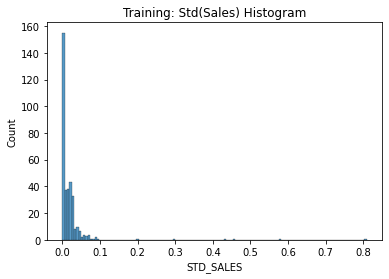

[Text(0.5, 1.0, 'Training: Std(Sales) Histogram')]

In [0]:
sns.histplot(data=df_train,x="STD_SALES").set(title='Training: Std(Sales) Histogram')

Out[9]:

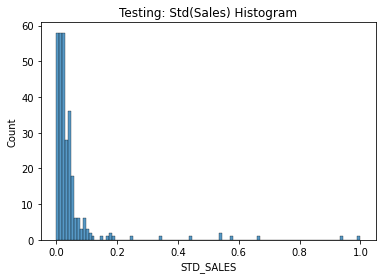

[Text(0.5, 1.0, 'Testing: Std(Sales) Histogram')]

In [0]:
sns.histplot(data=df_test,x="STD_SALES").set(title='Testing: Std(Sales) Histogram')

In [0]:
def categorizeSales(threshold, n):
    return "1" if n >= threshold else "0"

def runModel(df_train, df_test, threshold):
    print("Threshold: {}".format(str(threshold)))
    df_train["QTY_SALES"] = df_train["STD_SALES"].apply(lambda x: categorizeSales(threshold, x))
    df_test["QTY_SALES"] = df_test["STD_SALES"].apply(lambda x: categorizeSales(threshold, x))

    # ResNet50V2
    datagen_aug = keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    train_generator_aug=datagen_aug.flow_from_dataframe(
        dataframe=df_train,
        directory="/dbfs/FileStore/Bookimages/",
        x_col="name",
        y_col="QTY_SALES",
        batch_size=32,
        class_mode="binary",
        target_size=(224,224))
    test_generator_aug=datagen_aug.flow_from_dataframe(
        dataframe=df_test,
        directory="/dbfs/FileStore/Bookimages2022/",
        x_col="name",
        y_col="QTY_SALES",
        batch_size=32,
        class_mode="binary",
        target_size=(224,224))

    base_model = ResNet50V2(weights='imagenet')
    resnet50_model_aug = keras.models.Sequential()
    resnet50_model_aug.add(base_model)
    resnet50_model_aug.add(keras.layers.Flatten())
    resnet50_model_aug.add(keras.layers.Dense(128, activation='relu'))
    resnet50_model_aug.add(keras.layers.Dropout(0.3))
    resnet50_model_aug.add(keras.layers.Dense(1, activation='sigmoid'))
    resnet50_model_aug.layers[0].trainable = False

    resnet50_model_aug.compile(optimizer='adam',
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    resnet50_model_aug.summary()

    resnet50_model_aug.fit(
        train_generator_aug,
        steps_per_epoch=train_generator_aug.n//train_generator_aug.batch_size,
        epochs=25,
        validation_data=test_generator_aug,
        validation_steps=test_generator_aug.n//test_generator_aug.batch_size,
    )

    model_file_name = "resnet50_model_aug_{}.h5".format(str(threshold))
    resnet50_model_aug.save("/tmp/{}".format(model_file_name))
    dbutils.fs.cp("file:/tmp/{}".format(model_file_name), "dbfs:/FileStore/model/{}".format(model_file_name))

In [0]:
def csv_download_button(df, fname):
    csv = df.to_csv(index=False) #if no filename is given, a string is returned
    b64 = base64.b64encode(csv.encode()).decode()
    href = f'<a href="data:file/csv;base64,{b64}" download="{fname}">Download CSV File: {fname}</a>'
    display(HTML(href))

def buildClsTable(y, y_pred):
    report = classification_report(y, y_pred, output_dict=True)
    return pd.DataFrame(report).transpose()

def predict(df_train, df_test, threshold):
    df_train["QTY_SALES"] = df_train["STD_SALES"].apply(lambda x: categorizeSales(threshold, x))
    df_test["QTY_SALES"] = df_test["STD_SALES"].apply(lambda x: categorizeSales(threshold, x))

    resnet50_model_aug = keras.models.load_model("/dbfs/FileStore/model/resnet50_model_aug_{}.h5".format(str(threshold)))

    predict_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    pred_train_generator=predict_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory="/dbfs/FileStore/Bookimages/",
        x_col="name",
        y_col="QTY_SALES",
        batch_size=32,
        class_mode="binary",
        target_size=(224,224))

    pred_test_generator=predict_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory="/dbfs/FileStore/Bookimages2022/",
        x_col="name",
        y_col="QTY_SALES",
        batch_size=32,
        class_mode="binary",
        target_size=(224,224))

    pred_train = resnet50_model_aug.predict(pred_train_generator,pred_train_generator.n//pred_train_generator.batch_size)
    pred_test = resnet50_model_aug.predict(pred_test_generator,pred_test_generator.n//pred_test_generator.batch_size)

    df_train_predicted = df_train[["PRODUCT_ID", "QTY_SALES"]].copy(deep=True)
    df_train_predicted["QTY_SALES_PREDICTED"] = np.round(pred_train)
    df_train_predicted["QTY_SALES"] = df_train_predicted["QTY_SALES"].astype("int64")
    df_train_predicted["QTY_SALES_PREDICTED"] = df_train_predicted["QTY_SALES_PREDICTED"].astype("int64")
    df_train_predicted["CORRECT_PRED"] = df_train_predicted.apply(lambda x: "Yes" if x["QTY_SALES"] == x["QTY_SALES_PREDICTED"] else "No", axis=1)

    df_test_predicted = df_test[["PRODUCT_ID", "QTY_SALES"]].copy(deep=True)
    df_test_predicted["QTY_SALES_PREDICTED"] = np.round(pred_test)
    df_test_predicted["QTY_SALES"] = df_test_predicted["QTY_SALES"].astype("int64")
    df_test_predicted["QTY_SALES_PREDICTED"] = df_test_predicted["QTY_SALES_PREDICTED"].astype("int64")
    df_test_predicted["CORRECT_PRED"] = df_test_predicted.apply(lambda x: "Yes" if x["QTY_SALES"] == x["QTY_SALES_PREDICTED"] else "No", axis=1)

    df_train_cls = buildClsTable(df_train_predicted["QTY_SALES"].tolist(), np.round(pred_train))
    df_test_cls = buildClsTable(df_test_predicted["QTY_SALES"].tolist(), np.round(pred_test))

    train_pred_csv = "train_pred_{}.csv".format(str(threshold))
    test_pred_csv = "test_pred_{}.csv".format(str(threshold))
    train_cls_table_csv = "train_cls_{}.csv".format(str(threshold))
    test_cls_table_csv = "test_cls_{}.csv".format(str(threshold))

    df_train_predicted.to_csv("/tmp/{}".format(train_pred_csv), index=False)
    df_test_predicted.to_csv("/tmp/{}".format(test_pred_csv), index=False)
    df_train_cls.to_csv("/tmp/{}".format(train_cls_table_csv), index=False)
    df_test_cls.to_csv("/tmp/{}".format(test_cls_table_csv), index=False)

    dbutils.fs.cp("file:/tmp/{}".format(train_pred_csv), "dbfs:/FileStore/output/{}".format(train_pred_csv))
    dbutils.fs.cp("file:/tmp/{}".format(test_pred_csv), "dbfs:/FileStore/output/{}".format(test_pred_csv))
    dbutils.fs.cp("file:/tmp/{}".format(train_cls_table_csv), "dbfs:/FileStore/output/{}".format(train_cls_table_csv))
    dbutils.fs.cp("file:/tmp/{}".format(test_cls_table_csv), "dbfs:/FileStore/output/{}".format(test_cls_table_csv))

def downloadOutput(threshold):
    train_pred_csv = "train_pred_{}.csv".format(str(threshold))
    test_pred_csv = "test_pred_{}.csv".format(str(threshold))
    train_cls_table_csv = "train_cls_{}.csv".format(str(threshold))
    test_cls_table_csv = "test_cls_{}.csv".format(str(threshold))

    df1 = pd.read_csv("/dbfs/FileStore/output/{}".format(train_pred_csv))
    df2 = pd.read_csv("/dbfs/FileStore/output/{}".format(test_pred_csv))
    df3 = pd.read_csv("/dbfs/FileStore/output/{}".format(train_cls_table_csv))
    df4 = pd.read_csv("/dbfs/FileStore/output/{}".format(test_cls_table_csv))

    csv_download_button(df1, train_pred_csv)
    csv_download_button(df2, test_pred_csv)
    csv_download_button(df3, train_cls_table_csv)
    csv_download_button(df4, test_cls_table_csv)

In [0]:
for t in range(1, 11):
    threshold = t / 100
    runModel(df_train, df_test, threshold)

Threshold: 0.01
Found 355 validated image filenames belonging to 2 classes.
Found 297 validated image filenames belonging to 2 classes.
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50v2_weights_tf_dim_ordering_tf_kernels.h5
 16384/102869336 [..............................] - ETA: 0s 4202496/102869336 [>.............................] - ETA: 7s 12288000/102869336 [==>...........................] - ETA: 2s 16785408/102869336 [===>..........................] - ETA: 3s 26066944/102869336 [======>.......................] - ETA: 1s 34406400/102869336 [=========>....................] - ETA: 1s 41951232/102869336 [===========>..................] - ETA: 1s 50339840/102869336 [=============>................] - ETA: 1s 59203584/102869336 [================>.............] - ETA: 0s 67117056/102869336 [==================>...........] - ETA: 0s 75505664/102869336 [=====================>........] - ETA: 0s 83894272/102869336 [=======================>......] - ETA: 0s 92282880/102869336 [=========================>....] - ETA: 0s101720064/102869336 [============================>.] - ETA: 0s102875136/102869336 [==============================] - 2s 0us/step
102883328/102869336 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type) Output Shape Param # 
=================================================================
 resnet50v2 (Functional) (None, 1000) 25613800 
 
 flatten (Flatten) (None, 1000) 0 
 
 dense (Dense) (None, 128) 128128 
 
 dropout (Dropout) (None, 128) 0 
 
 dense_1 (Dense) (None, 1) 129 
 
=================================================================
Total params: 25,742,057
Trainable params: 128,257
Non-trainable params: 25,613,800
_________________________________________________________________
Epoch 1/25
 1/11 [=>............................] - ETA: 1:09 - loss: 0.6934 - accuracy: 0.5625 2/11 [====>.........................] - ETA: 17s - loss: 0.6928 - accuracy: 0.5469  3/11 [=======>......................] - ETA: 15s - loss: 0.6927 - accuracy: 0.5312 4/11 [=========>....................] - ETA: 13s - loss: 0.6926 - accuracy: 0.5234 5/11 [============>.................] - ETA: 11s - loss: 0.6926 - accuracy: 0.5375 6/11 [===============>..............] - ETA: 9s - loss: 0.6924 - accuracy: 0.5417  7/11 [==================>...........] - ETA: 6s - loss: 0.6924 - accuracy: 0.5487

In [0]:
for t in range(1, 11):
    threshold = t / 100
    predict(df_train, df_test, threshold)